In [2]:
import numpy as np,pandas as pd, networkx as nx, itertools,re
from collections import Counter
import copy,random
from sklearn.neighbors import KDTree

In [3]:
def color(x):
    if 'x' in str(x):
        return('red')
    else:
        return('blue')

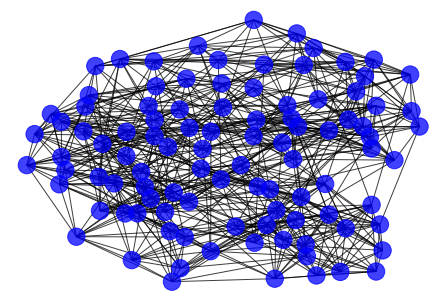

In [27]:
# generating random graph
G = nx.watts_strogatz_graph(100, 15, .25, seed=1)
nx.draw(G,node_color=[color(x) for x in G.nodes()],alpha=.75)

In [28]:
# adding H into G
H = nx.Graph() # to track what edges have been added

n = len(G)

# creating attacking nodes
X_len = int(3*np.log(n))
X = ['x{}'.format(i) for i in range(X_len)]

# creating and inserting edges for attacked nodes
possible_combos = list(itertools.combinations(X,3)) + list(itertools.combinations(X,2)) + list(itertools.combinations(X,1))
wx = random.sample(possible_combos,int(np.square(np.log(n))))

#use to identify nearly all nodes (2^{X_len-1})
'''
X_len = int(min(int(3*np.log(n)),2+np.log(n)//np.log(2)))
X = ['x{}'.format(i) for i in range(X_len)]
wx = random.sample(list(itertools.product(*[(x,None) for x in X])), min(n,2**(len(X)-1))) 
'''

i = 0
attacked_nodes = {}
for w in np.random.choice(G.nodes(),len(wx),replace=False):
    G.add_edges_from(list(itertools.product([w],list(wx[i]))))
    H.add_edges_from(list(itertools.product([w],list(wx[i]))))
    attacked_nodes[w]=wx[i]
    i+=1


# adding ring around attacking nodes for identification  
for i in range(len(X)-1):
    G.add_edge(X[i],X[i+1])
    H.add_edge(X[i],X[i+1])

# adding random edges between attacking nodes
for pair in itertools.combinations(X,2):
    if np.random.random()>.75:
        G.add_edge(pair[0],pair[1])
        H.add_edge(pair[0],pair[1])

#G.remove_node(None) 
#H.remove_node(None) 

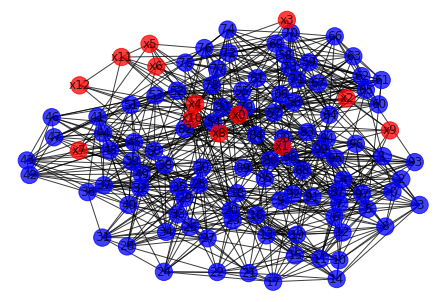

In [29]:
nx.draw(G,node_color=[color(x) for x in G.nodes()],alpha=.75,with_labels=True)

In [30]:
# creating relabeled copy
A = copy.deepcopy(G)
rand_ints = random.sample(range(10*len(A)),2*len(A))
dict_new_edges = {list(A.nodes())[i]:rand_ints[i] for i in range(len(A.nodes))}
A = nx.relabel_nodes(A, dict_new_edges, copy=True)

In [31]:
def find_new_X(A, H, node, i, X, new_X):
    
    if len(new_X)==len(X):
        return True
    
    # check degree matches
    if len(A.adj[node])!=len(H.adj[X[i]]):
        return False
    
    new_X.append(node)
    
    # check adjacent nodes
    for adjacent in A.adj[node]:  
        if adjacent in new_X:
            continue
        if find_new_X(A,H,adjacent, i+1, X, new_X):
            return True # match found
    
    new_X.pop() # remove this node from list
    return False # no more matching nodes found

def check_structure(A,H,X,new_X):
    
    for (u,v) in H.edges():
        
        # check for w nodes
        if (u not in X) or (v not in X):
            continue
            
        index1 = X.index(u)
        index2 = X.index(v)
        if (new_X[index1], new_X[index2]) not in A.edges():
            return False
        
    return True

for node in A.nodes():
    
    new_X = []
    if find_new_X(A,H,node,0, X, new_X):
        if check_structure(A,H,X,new_X):
            break
        
print("Malicious nodes inserted: ",X)
print("Malicious nodes retrieved: ", new_X) # contains encoded value of x

print("Actual malicious nodes: ",[dict_new_edges[node] for node in X]) # compare results

Malicious nodes inserted:  ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12']
Malicious nodes retrieved:  [1114, 957, 523, 266, 899, 373, 624, 1085, 1126, 390, 852, 1011, 423]
Actual malicious nodes:  [1114, 957, 523, 266, 899, 373, 624, 1085, 1126, 390, 852, 1011, 423]


In [32]:
# express each node in A as a binary number (each digit corresponding to the existance of an edge to each x in X)
vfunc_A = np.vectorize(lambda x: np.array([int(x_node in A[x]) for x_node in new_X]),signature='()->(n)')
A_nodes = [node for node in A.nodes() if node not in new_X]
A_tree = vfunc_A(A_nodes)

# express each node in H as a binary number (each digit corresponding to the existance of an edge to each x in X)
vfunc_H = np.vectorize(lambda x: np.array([int(x_node in H[int(x)]) for x_node in X]),signature='()->(n)')
H_nodes = [node for node in H.nodes() if not isinstance(node, str)]
H_tree = vfunc_H(H_nodes)

# find matches
tree = KDTree(A_tree, leaf_size=2)
ind = tree.query(H_tree, k=1)[1]

reveal = pd.DataFrame()
reveal['Node'] = H_nodes
reveal['Prediction'] = [A_nodes[x] for x in ind.flatten()]
reveal['Actual'] =  [dict_new_edges[x] for x in H_nodes]
reveal.head(10)

,Node,Prediction,Actual
0,78,313,313
1,25,823,823
2,92,876,876
3,69,516,516
4,9,286,286
5,39,116,116
6,59,627,627
7,6,246,246
8,95,586,586
9,56,442,442


In [33]:
print('Number of nodes in G:',len(G)-len(X))
print('Inserted nodes:', len(X))
print('% nodes identified',100*len(reveal)/(len(G)-len(X)))

Number of nodes in G: 100
Inserted nodes: 13
% nodes identified 21.0
